In [1]:
import os
import sys
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from plato.optimisation import Optimisation
from plato.plate_torques import PlateTorques
from plato.plot import PlotReconstruction

The below cell loads a `PlateTorques` object for the Müller et al. (2016) reconstruction by providing the ages of interest and the model string identifier "Muller2016", which automatically downloads the relevant files from the GPlately DataServer.

In [2]:
# Set parameters
# Plate reconstruction
reconstruction_name = "Muller2016" 

# Reconstruction ages of interest
# ages = np.arange(0, 51)
ages = [0, 50]

# Set directory to save the results
results_dir = "01-Results"

# Set up PlateTorques object
M2016 = PlateTorques(reconstruction_name = reconstruction_name, ages = ages, files_dir=results_dir, DEBUG_MODE=True)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


Calculating RMS velocities: 100%|██████████| 2/2 [00:00<00:00, 35.79it/s]


Saving

The below cell saves the PlateTorques object 

In [3]:
# M2016.save_all()

Sampling and torque calculation

The below cell calls the `sample_all` method of the `PlateTorques` object to sample seafloor ages at subduction zones and grid points.

Then, the cell calls the `calculate_all_torques` method of the `PlateTorques` object to calculate all torques.

In [4]:
# Sample seafloor ages
M2016.sample_seafloor_ages()

# Calculate torques
M2016.calculate_all_torques()

Calculating RMS velocities: 100%|██████████| 2/2 [00:00<00:00, 35.76it/s]
Calculating driving torque: 2it [00:00, 97.02it/s]
Calculating residual torque: 100%|██████████| 1/1 [00:00<00:00, 49.11it/s]


The below cells extract the magnitude RMS velocity and the residual torque for the the Pacific plate for the ages of interest and plot these.

In [5]:
# Extract data of interest
rms_velocity = M2016.extract_data_through_time(plateIDs = 901, var = "velocity_rms_mag")
rms_azimuth = M2016.extract_data_through_time(plateIDs = 901, var = "velocity_rms_azi")
residual_torque = M2016.extract_data_through_time(plateIDs = 901, var = "residual_torque_mag")
driving_torque = M2016.extract_data_through_time(plateIDs = 901, var = "driving_torque_mag")

In [6]:
# Convert cm to in for plotting figures
cm2in = 0.3937008

# Set projection for maps
projection = ccrs.Robinson(central_longitude=160)

# Set font size and family
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Arial"

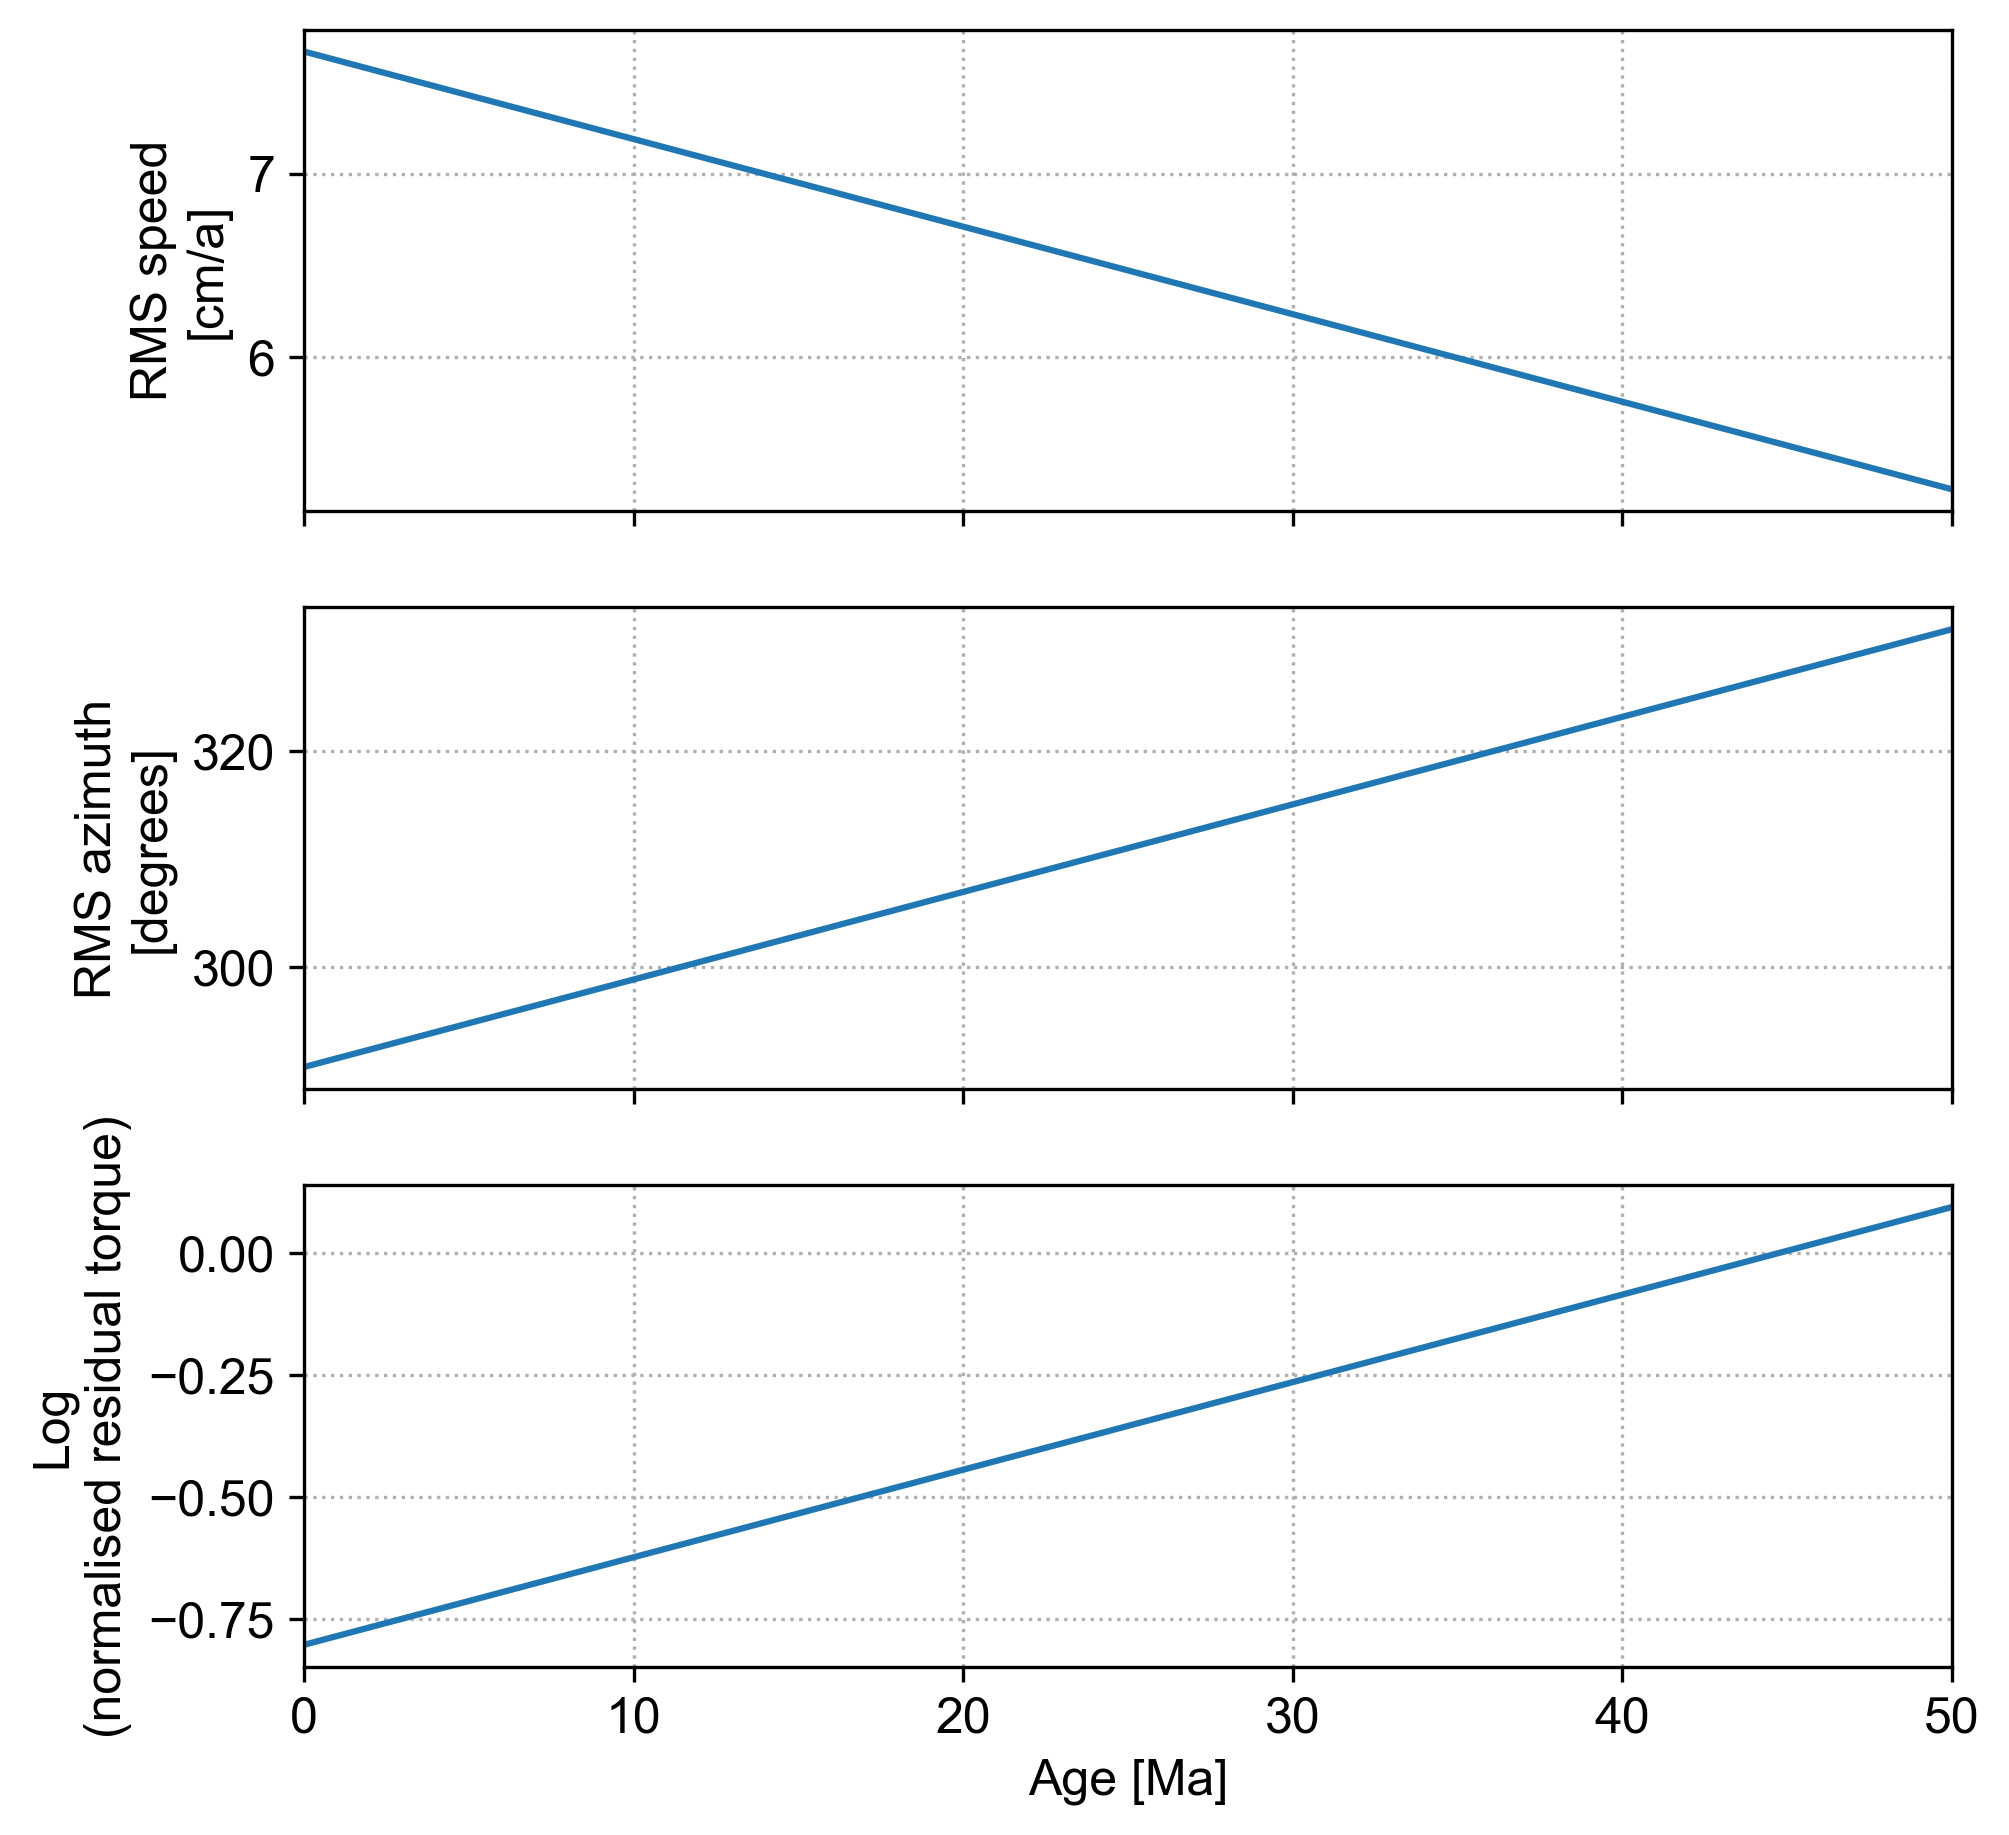

In [7]:
# Plot residual magnitudes of RMS velocity and residual torque through time
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18*cm2in, 18*cm2in), dpi=300)
ax1.plot(rms_velocity["Age"], rms_velocity[901])
ax2.plot(rms_velocity["Age"], rms_azimuth[901])
ax3.plot(rms_velocity["Age"], np.log10(residual_torque[901]/driving_torque[901]))

for ax in [ax1, ax2, ax3]:
    ax.grid(ls=":")
    ax.set_xlim(rms_velocity["Age"].min(), rms_velocity["Age"].max())

ax1.set_ylabel("RMS speed\n[cm/a]")
ax2.set_ylabel("RMS azimuth\n[degrees]")
ax3.set_ylabel("Log\n(normalised residual torque)")
ax3.set_xlabel("Age [Ma]")

fig.savefig("01-Figures/Pacific_velocity_residual.png", dpi=300, bbox_inches="tight")

plt.show()

The below cell 

In [8]:
optimise_M2016 = Optimisation(M2016)

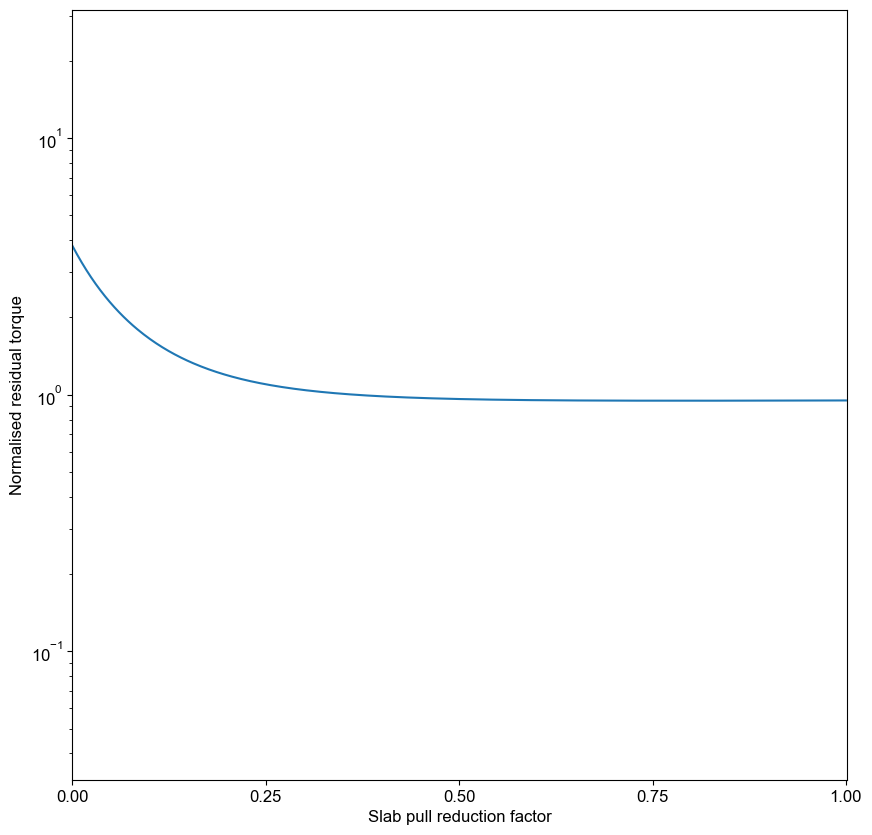

(0.7895812625250501, 1.8398544181329632e+27, 1.7425528521328998e+27)

In [24]:
optimise_M2016.find_slab_pull_coefficient(plateIDs = 901, age = 50, plot = True)

In [10]:
M2016_plot = PlotReconstruction(M2016)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
No continents in Muller2016.


Warning 1: /Users/thomas/Library/Caches/gplately/Muller2016.unzip/Muller_etal_2016_AREPS_Supplement_v1.17/Shapefiles/Coastlines/Global_coastlines_2015_v1_low_res.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.


Interpolating data to grid


Generating velocity grids: 100%|██████████| 1/1 [00:00<00:00, 491.89it/s]


Interpolating data to grid


Generating velocity grids: 100%|██████████| 1/1 [00:00<00:00, 486.86it/s]


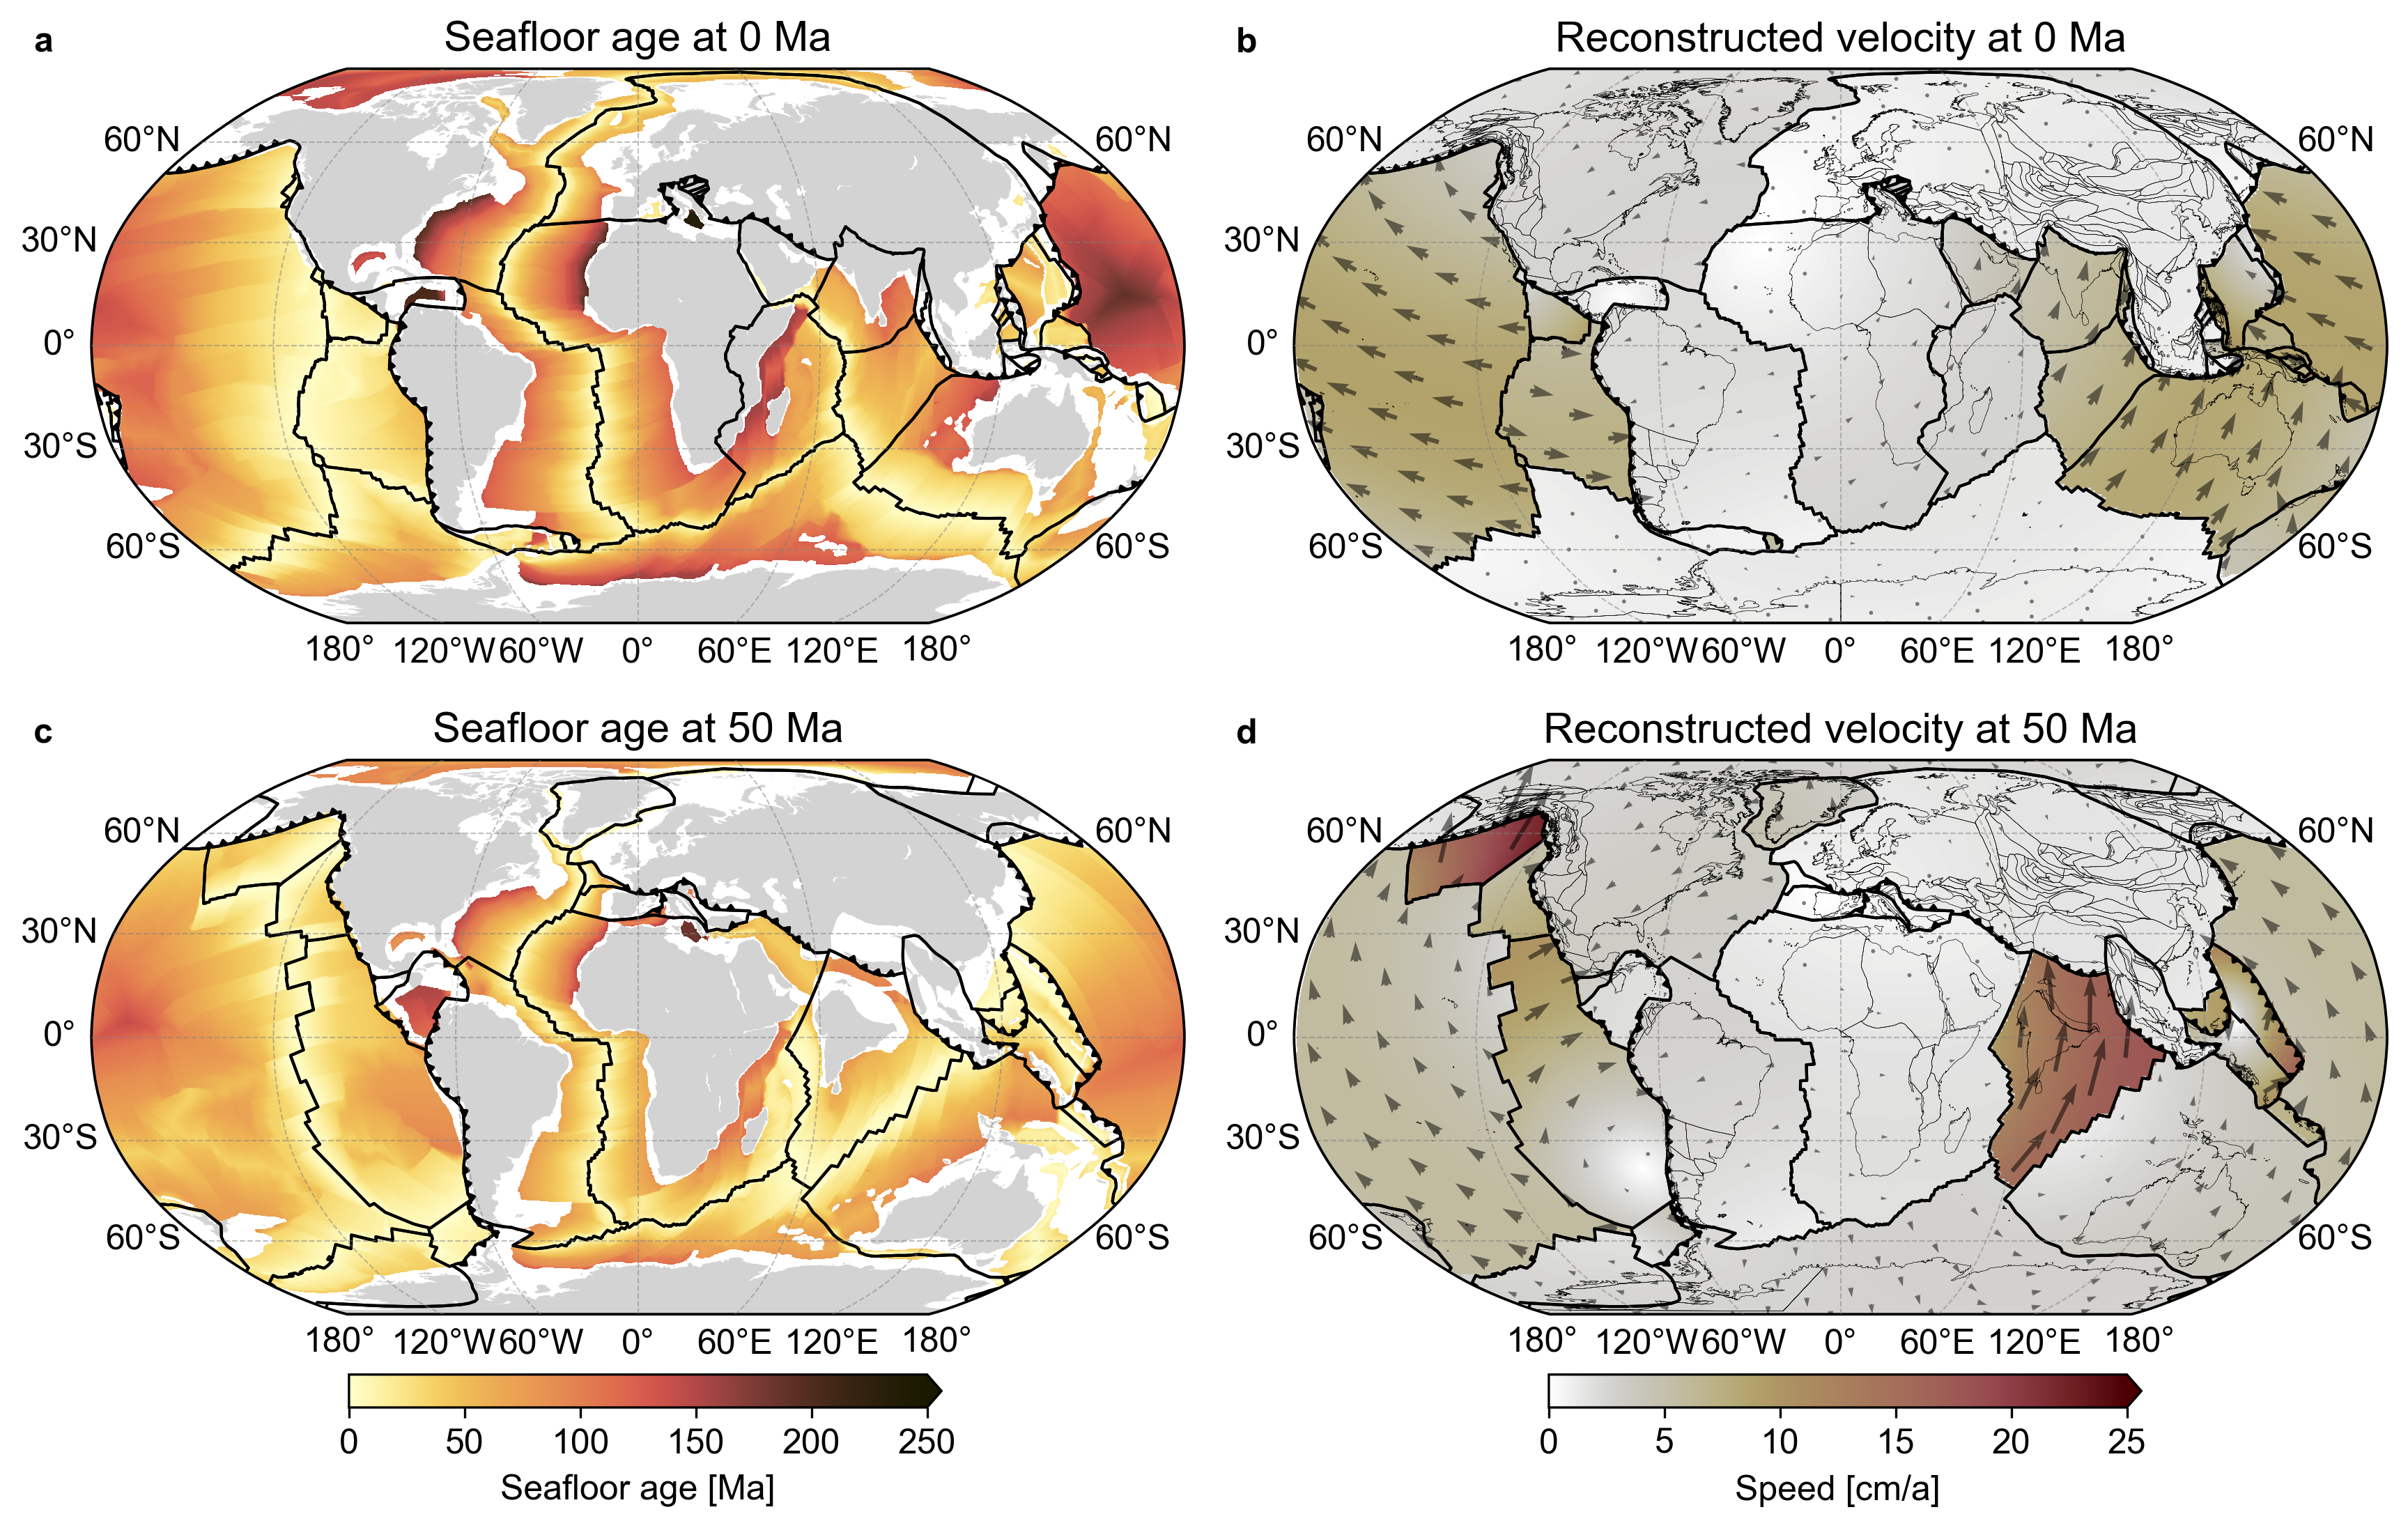

In [11]:
fig = plt.figure(figsize=(18*cm2in*2, 10*cm2in*2), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], wspace=0.1)

labels = ["a", "b", "c", "d"]
k = 0
for i in range(0, 2):
    for j in range(0, 2):
        ax = plt.subplot(gs[i, j], projection=ccrs.Robinson())
        age = 0 if i == 0 else 50
        if j == 0:
            seafloor_ages = M2016_plot.plot_seafloor_age_map(ax, age=age)
            ax.set_title(f"Seafloor age at {age} Ma")
        else:
            speeds, velocities = M2016_plot.plot_velocity_map(ax, age=age, normalise_vectors=False)
            ax.set_title(f"Reconstructed velocity at {age} Ma")
        ax.annotate(labels[k], xy=(-0.053, 1.03), xycoords="axes fraction", fontsize=12, fontweight="bold")
        k += 1

# Create new grids for the colourbars
cax1 = fig.add_axes([0.212, 0.06, 0.2, 0.02])
cax2 = fig.add_axes([0.617, 0.06, 0.2, 0.02])

# Create a colorbar below the subplots
cbar1 = plt.colorbar(seafloor_ages, cax=cax1, orientation="horizontal", extend="max", extendfrac=25e-3)
cbar2 = plt.colorbar(speeds, cax=cax2, orientation="horizontal", extend="max", extendfrac=25e-3)

# Set colorbar label
cbar1.set_label("Seafloor age [Ma]", labelpad=5)
cbar2.set_label("Speed [cm/a]", labelpad=5)

fig.savefig("01-Figures/Reconstruction_maps.png", dpi=300, bbox_inches="tight")
plt.show()